# Поиск неэффективных операторов

## Задача:
Помочь компании «Нупозвони» найти самых неэффективных операторов. К признакам низкой эффективности относятся:
- Большое количество пропущенных входящих вызовов,
- Долгое ожидание ответа при входящих внешних вызовах,
- Мало исходящих вывозов в случае колл-центров, специализирующихся на обзвонах, а не обработке входящих звонков,
- Частая переадресовка вызова другому оператору.

Приведенные выше признаки приведены в ТЗ. Они кажуться вполне адекватными, однако, оставляю за собой право по ходу анализа, в случае выявления других многообещающих признаков или необходимости изменить изначальную стратегию, расширить или изменить список.

По поводу определения границ по каждому признаку: на данном этапе, кажется уместным, взять 25-й процентиль - как слабые показатели.

Более точный и полный портрет неэффективного оператора можно будет описать лишь на последних этапах работы) Пока можно предположить, что операторы, у которых значения приведенных в ТЗ признаках лежат в первом квартиле - неэффективны, по ходу проекта оставлю за собой право поменять выбранную методологию. 

## План проекта:

1. Проведение исследовательского анализа данных
   - Импортирование данных из датасетов `telecom_dataset.csv` и `telecom_clients.csv`
   - Изучение основных статистических характеристик данных
   - Обработка и очистка данных от пропущенных значений и выбросов
   - Визуализация данных для получения представления о распределении признаков

2. Определение неэффективных операторов
   - Вычисление метрик эффективности операторов на основе заданных признаков
   - Ранжирование операторов по уровню эффективности
   - Выбор пороговых значений для определения неэффективных операторов

3. Проверка статистических гипотез
   - Сравнение средних значений метрик эффективности между эффективными и неэффективными операторами
   - Применение статистических тестов для проверки значимости различий

## Гипотезы:
- Проверить что есть статистически значимое различие в средних значениях всех выбранных выше признаков у эффективных и неэффективных операторов.
   
## Описание данных:

Датасеты описывают использование услуг компании «Нупозвони» - провайдера виртуальной телефонии. Клиентами компании являются колл-центры, которые распределяют входящие вызовы на операторов и совершают исходящие вызовы силами операторов. Операторы также могут делать внутренние вызовы - вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv`:
- `user_id`: Идентификатор клиентского аккаунта колл-центра в сервисе
- `date`: Дата статистики
- `direction`: Направление вызовов (out - исходящий вызов, in - входящий вызов)
- `internal`: Является ли звонок внутренним звонком между операторами клиента
- `operator_id`: Идентификатор оператора
- `is_missed_call`: Является ли звонок пропущенным
- `calls_count`: Количество звонков
- `call_duration`: Длительность звонка (без учета времени ожидания)
- `total_call_duration`: Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:
- `user_id`: Идентификатор клиентского аккаунта в сервисе
- `tariff_plan`: Текущий тарифный план клиента
- `date_start`: Дата регистрации клиента в сервисе

## Проведение исследовательского анализа данных

In [1]:
from dataclasses import dataclass
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import display
import ipywidgets as widgets
import itertools
from http import HTTPStatus
import logging
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import re
import requests
from scipy import stats as sst
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, silhouette_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import sys
from typing import Optional, Union
import warnings

load_dotenv()
# настроимся на приятный вечер
register_matplotlib_converters()
warnings.filterwarnings('ignore')

logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO)


# будем следить за поведением программы и за пользователями
# с помощью кастомного исключения на все случаи жизни
class BaseException(Exception):
    """Напишем базовое исключение"""

    def __init__(self, text):
        """активация..."""
        self.text = text

In [2]:
DEBUG = False

def url_is_valid(url: str) -> bool:
    if not isinstance(url, str):
        raise ValueError('url must be string')
    return True if requests.get(url).status_code  == HTTPStatus.OK else False

PATH_ERROR_TEXT = 'некоррекнто прописан путь к данным'
def read_file(path_1: str, path_2: str, sep: str = ',') -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    # проверим, что файл существует, также стоит проверить
    # что это именно файл, если это не так, то нет смысла продолжать
    if (os.path.exists(path_1) and os.path.isfile(path_1)) or url_is_valid(path_1):
        logging.info('works online')
        data = pd.read_csv(path_1, sep=sep)
        logging.info('read file sucsess')
        return data
    elif os.path.exists(path_2) and os.path.isfile(path_2):
        logging.info('works lokaly')
        data = pd.read_csv(path_2, sep=sep)
        logging.info('read file sucsess')
        return data
    else:
        logging.critical(PATH_ERROR_TEXT)
        raise BaseException(PATH_ERROR_TEXT) and sys.exit()


def get_full_information(data: pd.DataFrame) -> None:
    """
    Функция дает нам полное
    представление о данных
    """
    logging.info('первое представление о данных')
    for _ in [data.head(), data.describe()]:
        display(_)
        print("*"*100)
    data.info()
    data.hist(figsize=(15, 10))
    plt.show();


def check_names_columns(data: pd.DataFrame) -> list[str]:
    """
    Функция проверяет, соответствуют
    ли имена колонок snake_style
    """
    columns_to_change = []
    pattern = r"^[a-z]+(_[a-z]+)*$"
    for column in data.columns:
        match = re.match(pattern, column)
        if match:
            continue
        else:
            columns_to_change.append(column)
    logging.info('изменим название колонок:')
    logging.info(columns_to_change)
    return columns_to_change


def test_check_names_columns():
    # Тестовый датафрейм с корректными именами колонок
    df1 = pd.DataFrame({'first_name': ['John', 'Jane'], 'last_name': ['Doe', 'Smith']})
    assert check_names_columns(df1) == []

    # Тестовый датафрейм с некорректными именами колонок
    df2 = pd.DataFrame({'FirstName': ['John', 'Jane'], 'last name': ['Doe', 'Smith']})
    assert check_names_columns(df2) == ['FirstName', 'last name']

    # Тестовый датафрейм с пустыми данными
    df3 = pd.DataFrame()
    assert check_names_columns(df3) == []

    # Тестовый датафрейм с одной колонкой
    df4 = pd.DataFrame({'name': ['John', 'Jane']})
    assert check_names_columns(df4) == []

    # Тестовый датафрейм с двумя колонками, одна из которых корректная
    df5 = pd.DataFrame({'first_name': ['John', 'Jane'], 'last name': ['Doe', 'Smith']})
    assert check_names_columns(df5) == ['last name']
    print('OK')


NOT_LIST = 'входные данные должны быть в форме списка'
NOT_STR = 'в списке должны быть строки'
def change_name_columns(columns_to_change: list[str]) -> dict[str, str]:
    """
    Функция возвращает словарь,
    ключ- неправильное название колонки
    значение - верное
    """
    def sup_right_name(column:str) ->str:
        cont: list[str] = list(column)
        new_name: str = ''
        while cont:
            char = cont.pop()
            if len(cont) == 0:
                new_name = char.lower() + new_name
            elif char.isupper():
                new_name = f'_{char.lower()}' + new_name
            else:
                new_name = char + new_name
        return new_name
    right_names = []
    # проверим, что нам подсунули на входе,
    # это нужно, для обеспечения устойчивости программы
    if not isinstance(columns_to_change, list):
        raise BaseException(NOT_LIST)
    for column in columns_to_change:
        if not isinstance(column, str):
            raise BaseException(NOT_STR)
    else:
        for column in columns_to_change:
            if len(column.split()) != 1:
                column = '_'.join(column.split())
                column = column.lower()
            elif column.isupper():
                column = column.lower()
            elif re.match(r'^[a-zA-Z]+$', column):
                column = sup_right_name(column)
            right_names.append(column)
    columns = {c:r for c,r in zip(columns_to_change, right_names)}
    return columns


def test_change_name_columns():
    # Тестовый список с корректными названиями колонок
    columns1 = ['first_name', 'last_name']
    assert change_name_columns(columns1) == {'first_name': 'first_name', 'last_name': 'last_name'}

    # Тестовый список с некорректными данными - не список
    columns2 = 'first_name, last_name'
    try:
        change_name_columns(columns2)
    except BaseException as e:
        assert str(e) == 'входные данные должны быть в форме списка'

    # Тестовый список с некорректными данными - не строки
    columns3 = ['first_name', 123]
    try:
        change_name_columns(columns3)
    except BaseException as e:
        assert str(e) == 'в списке должны быть строки'

    # Тестовый список с некорректными названиями колонок
    columns4 = ['FirstName', 'last name']
    assert change_name_columns(columns4) == {'FirstName': 'first_name', 'last name': 'last_name'}

    # Тестовый список с одним элементом
    columns5 = ['name']
    assert change_name_columns(columns5) == {'name': 'name'}

    # Тестовый список с элементами, требующими преобразований
    columns6 = ['First name', 'LASTNAME', 'Age']
    assert change_name_columns(columns6) == {'First name': 'first_name', 'LASTNAME': 'lastname', 'Age': 'age'}
    print('OK')


def find_nan(data: pd.DataFrame) -> dict:
    """
    Функция считает по каждой колонке, сколько в ней пропусков,
    если пропусков 0, то с колонкой все хорошо
    и ее мы трогать не будем
    """
    return {column: data[column].isna().sum()/len(data)
            for column in data.columns
            if data[column].isna().sum() != 0}


def test_find_nan():
    # Тестовый датафрейм с пропусками
    df1 = pd.DataFrame({'A': [1, 2, None, 4], 'B': [None, 6, 7, 8], 'C': [9, 10, 11, None]})
    assert find_nan(df1) == {'A': 0.25, 'B': 0.25, 'C': 0.25}

    # Тестовый датафрейм без пропусков
    df2 = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 10, 11, 12]})
    assert find_nan(df2) == {}
    print('OK')


def drop_nan_less_five_percent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция удаляет строки по колонкам,
    если кол-во пропусков в них составляло
    менее 5 процентов
    """
    columns_with_nan = find_nan(data)
    for column, percent in columns_with_nan.items():
        if percent < .05:
            data = data[data[column].notna()]
    return data


def test_drop_nan_less_five_percent():
    # Тестовый датафрейм с пропусками в колонке A (менее 5%)
    df1 = pd.DataFrame({'a': [None] + [i for i in range(20)], 'b': [i for i in range(21)]})
    assert drop_nan_less_five_percent(df1).equals(pd.DataFrame(data={'a': [float(i) for i in range(20)],
                                                                     'b':[i for i in range(1, 21)]},
                                                               index = [i for i in range(1,21)]))

    # Тестовый датафрейм с пропусками в колонках A и B (более 5%)
    df2 = pd.DataFrame({'A': [None, None, None, None], 'B': [None, None, None, None], 'C': [9, 10, 11, 12]})
    assert drop_nan_less_five_percent(df2).equals(df2)

    # Тестовый датафрейм без пропусков
    df3 = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 10, 11, 12]})
    assert drop_nan_less_five_percent(df3).equals(df3)
    print('OK')


def works_dupblicates(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция работает с дубликатами
    """
    # приведем значения колонок к нижнему регистру
    for column in data.columns:
        if data.dtypes[column] == 'object' and isinstance(data[column][0], str):
            data[column] = data[column].str.lower()
    # если появились дубликаты дропнем их
    if data.duplicated().sum() > 0:
        logging.info('нашли дубликаты и удалили их')
        privios_data = len(data)
        data = data.drop_duplicates()
        logging.info('потеря данных в %:')
        logging.info(round((1 - (len(data)/privios_data))*100, 2))
    else:
        logging.info('дубликатов не найдено')
    return data


def test_works_duplicates():
    df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'alice'],
                       'age': [25, 30, 35, 25],
                       'date': ['2020-01-01', '2020-02-02', '2020-03-03', '2020-01-01']})
    df_result = works_dupblicates(df)
    assert len(df_result) == 3
    assert not df_result.duplicated().any()
    print('ОК')


def change_type_to_date(data: pd.DataFrame) -> pd.DataFrame:
    """
    Меняет формат на время
    """
    pattern = r'\d{4}-\d{2}-\d{2}'
    for column in data.columns:
        match = re.match(pattern, str(data[column][0]))
        if match:
            data[column] = pd.to_datetime(data[column])
            logging.info('поменяли на временной формат колоку')
            logging.info(column)
    return data


def test_change_type_to_date():
    df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'alice'],
                       'age': [25, 30, 35, 40],
                       'date': ['2020-01-01', '2020-02-02', '2020-03-03', '2020-04-04']})
    df_result = change_type_to_date(df)
    assert isinstance(df_result['date'][0], pd.Timestamp)
    assert not isinstance(df_result['name'][0], pd.Timestamp)
    print('OK')


def testing():
    test_check_names_columns()
    test_change_name_columns()
    test_find_nan()
    test_drop_nan_less_five_percent()
    test_works_duplicates()
    test_change_type_to_date()


def process_data(path_1: str, path_2: str, sep: str=',')->pd.DataFrame:
    """
    Функция содержит основную логику
    первичной обработки данных
    """
    try:
        # читаем данные и выводим всю правду о них
        data = read_file(path_1, path_2, sep)
        get_full_information(data)

        # работаем с названиями колонок
        columns_to_change = check_names_columns(data)
        if len(columns_to_change) > 0:
            columns_with_correct_name = change_name_columns(columns_to_change)
            data = data.rename(columns=columns_with_correct_name)

        # поработаем с пропусками
        if len(find_nan(data)) > 0:
            data = drop_nan_less_five_percent(data)
            display(pd.DataFrame(data = {'columns': find_nan(data).keys(),
                                         'nan_percent': find_nan(data).values()}).style.background_gradient('coolwarm'))
        else:
            logging.info('пропусков не нашел')
            
        # приводим к нужным типам
        data = change_type_to_date(data)

        # уничтожаем дубликаты
        data = works_dupblicates(data)

        # фуххх, добрались до конца
        logging.info('выдыхай, бобер, первичная обработка данных окончена')
        return data

    # если были ошибки, не стоит их скрывать, скажем об этом прямо
    except BaseException as error_message:
        return(error_message)

if DEBUG:
    testing()

2024-05-02 21:52:40,488 - INFO - works online
2024-05-02 21:52:41,808 - INFO - read file sucsess
2024-05-02 21:52:41,810 - INFO - первое представление о данных


user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25

****************************************************************************************************


user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.000000  
75%             902.000000  
max          166155.000000

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


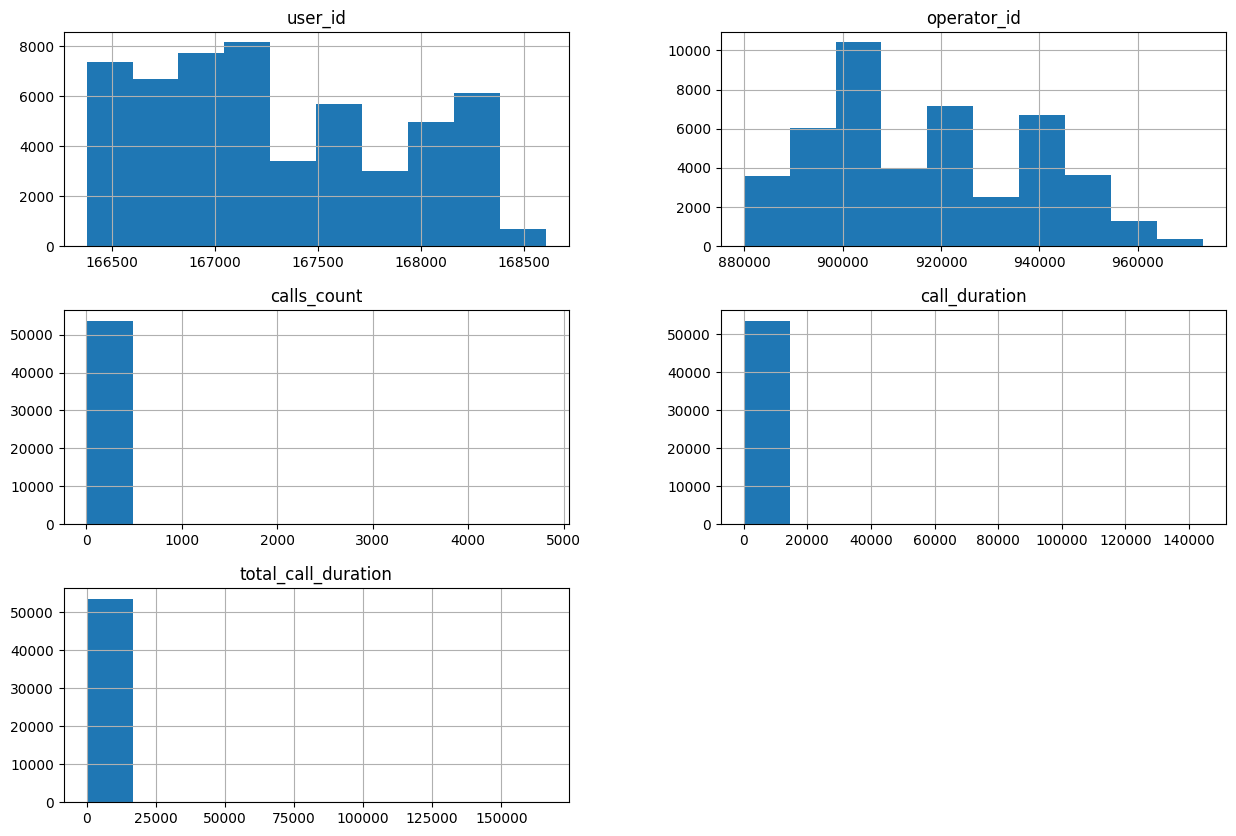

2024-05-02 21:52:42,986 - INFO - изменим название колонок:
2024-05-02 21:52:43,006 - INFO - []


2024-05-02 21:52:43,343 - INFO - поменяли на временной формат колоку
2024-05-02 21:52:43,344 - INFO - date
2024-05-02 21:52:43,383 - INFO - нашли дубликаты и удалили их
2024-05-02 21:52:43,414 - INFO - потеря данных в %:
2024-05-02 21:52:43,415 - INFO - 9.1
2024-05-02 21:52:43,417 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-02 21:53:17,031 - INFO - succsess


In [3]:
# имортируем данные и смотри на первичный анализ
data = process_data(os.getenv('telecom', ''), 'telecom_dataset.csv')

# доводим до ума типы
data['internal'] = data['internal'].astype('bool')

# Чуть погенерим признаки:

# время ожидания в секундах - int
data['waiting_time'] = data['total_call_duration'] - data['call_duration']
# среднее время разговора в секудах - float
data['avg_speak_time'] = data['call_duration'] / data['calls_count']
# коэффициент, сколько время ожидания составляет от среднего времени разговора % - float
data['waiting_time_per_call_duration'] = data.apply(
    lambda row: round(
        (row['waiting_time'] / row['avg_speak_time']) * 100, 2
    ) if row['avg_speak_time'] > 0 else 0,
    axis=1)
# коэффициент, сколько времени болтаем от общего времени разговора % - float
data['avg_speak_time_per_call_duration'] = data.apply(
    lambda row: round(
        (row['avg_speak_time'] / row['call_duration']) *100, 2
    ) if row['call_duration'] > 0 else 0,
    axis=1)
# направление вызова - bool
data['dir_sup'] = data['direction'].apply(
    lambda direction: True if direction == 'in' else False
)
# определяем пропущенные входящие звонки - bool
data['miss_in'] = data.apply(
    lambda row: True if row['is_missed_call'] == True and row['direction'] == 'in' else False, axis=1)
# определим входящие звонки при внешних вызовах с долгим ожидание ответа,
# в качестве границы возьмем 75-ый перцентиль - bool
data['long_waiting_in_int'] = data.apply(
    lambda row: True if row['waiting_time'] > np.percentile(data['waiting_time'], 75) and
    row['internal'] == False and row['direction'] =='in' else False, axis=1
)

# наведем красоту
NUMERICAL_COLUMNS = ['calls_count', 'call_duration',
                     'total_call_duration', 'waiting_time',
                     'avg_speak_time', 'waiting_time_per_call_duration',
                     'avg_speak_time_per_call_duration']

# заполнять пропуски тухлая идея, ставить заглушки - ну, можно, но можно и не ставить, я бы вообще удалил и не парился
data = data[data['operator_id'].notna()]
if len(find_nan(data).keys()) == 0:
    logging.info('succsess')

In [4]:
def plot_plotly_distr(columns: list[str], data: pd.DataFrame=data) -> None:
    n_g: int = int(len(columns)/2 + 1)
    fig = make_subplots(rows=n_g, cols=2)
    cols: list[int] = [1, 2] * n_g
    rows: list[int] = sorted([i for i in range(1, n_g + 1)] + [i for i in range(1, n_g + 1)])
    for column, row, cal in zip(columns, rows, cols):
        trace = go.Histogram(x=data[column].to_list(), name=column)
        fig.append_trace(trace, row, cal)
    fig.layout.width = 1000
    fig.layout.height = 1000
    fig.show()


plot_plotly_distr(NUMERICAL_COLUMNS)

2024-05-02 21:53:20,445 - INFO - works online
2024-05-02 21:53:20,726 - INFO - read file sucsess
2024-05-02 21:53:20,727 - INFO - первое представление о данных


user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

****************************************************************************************************


user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


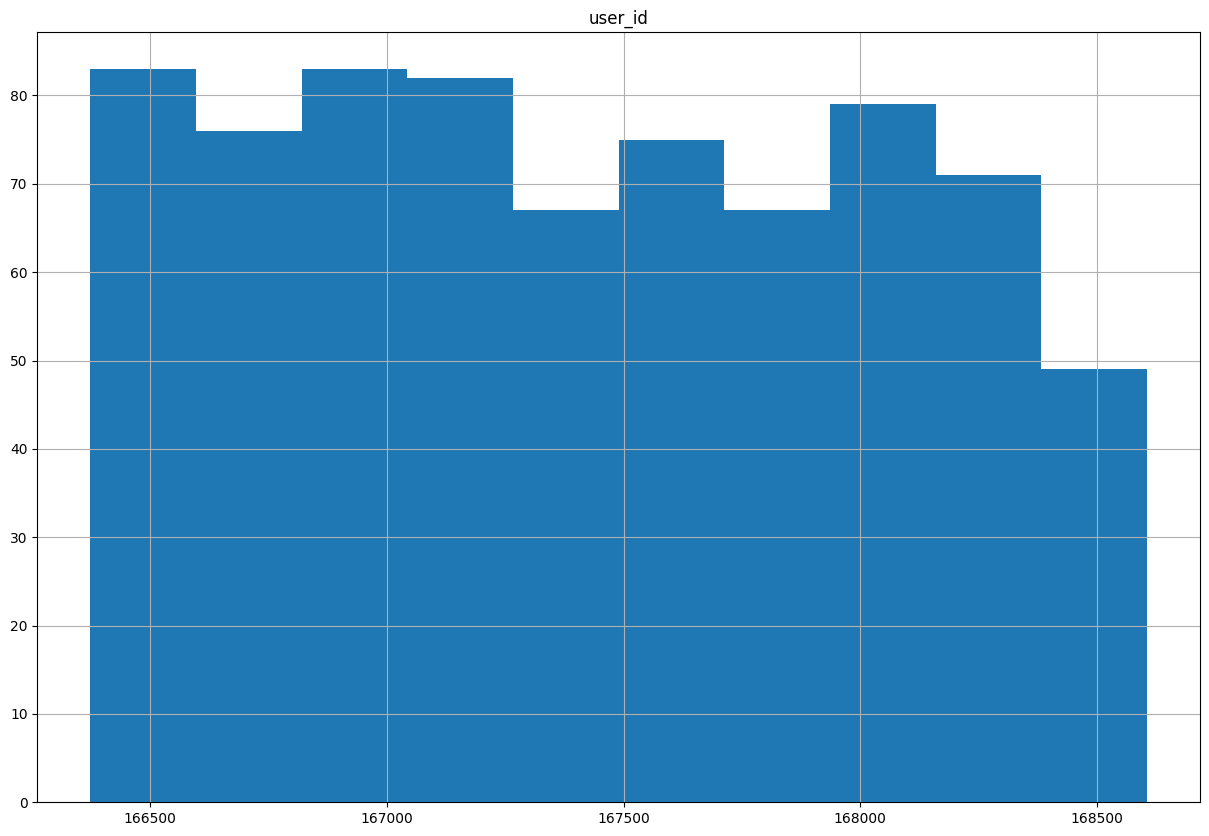

2024-05-02 21:53:20,966 - INFO - изменим название колонок:
2024-05-02 21:53:20,967 - INFO - []
2024-05-02 21:53:20,970 - INFO - пропусков не нашел
2024-05-02 21:53:20,978 - INFO - поменяли на временной формат колоку
2024-05-02 21:53:21,010 - INFO - date_start
2024-05-02 21:53:21,020 - INFO - дубликатов не найдено
2024-05-02 21:53:21,024 - INFO - выдыхай, бобер, первичная обработка данных окончена


In [5]:
# читаем и делаем первичный анализ второго сета
clients = process_data(os.getenv('telecom_c', ''), 'telecom_clients.csv')
# ну прям идельный датасет

In [6]:
# Посмотрим, что мы нагенерили и совпали ли ожидания с реальностью
def validate(data: pd.DataFrame, column: str) -> bool:
    """Проверяем есть ли колонка в сете."""
    return True if column in set(data.columns) else False

def count_unique_operator(data: pd.DataFrame) -> int:
    """Оформляем исключение для валидирующей функции."""
    if not validate(data, 'operator_id'):
        raise ValueError('Column not exsists')
    return len(data['operator_id'].unique())

def make_first_research(data: pd.DataFrame) -> None:
    """Смотрим на статистику по колонкам."""
    try:
        def analyse_column(data: pd.DataFrame) -> dict[str, str]:
            return {column : data[column].dtype for column in data.columns}
        for name, _type in analyse_column(data).items():
            print(f"в колонке {name}: тип данных - {_type}")
    except ValueError as message:
        print(message)

for frame, name in zip([data, clients],['data', 'clients']):
    display(widgets.HTML(value=f"<h3>{name}:</h3>"))
    if name == 'data':
        print(f"{count_unique_operator(data)} операторов представлено")
        make_first_research(frame)
    else:
        make_first_research(frame)

HTML(value='<h3>data:</h3>')

1092 операторов представлено
в колонке user_id: тип данных - int64
в колонке date: тип данных - datetime64[ns, UTC+03:00]
в колонке direction: тип данных - object
в колонке internal: тип данных - bool
в колонке operator_id: тип данных - float64
в колонке is_missed_call: тип данных - bool
в колонке calls_count: тип данных - int64
в колонке call_duration: тип данных - int64
в колонке total_call_duration: тип данных - int64
в колонке waiting_time: тип данных - int64
в колонке avg_speak_time: тип данных - float64
в колонке waiting_time_per_call_duration: тип данных - float64
в колонке avg_speak_time_per_call_duration: тип данных - float64
в колонке dir_sup: тип данных - bool
в колонке miss_in: тип данных - bool
в колонке long_waiting_in_int: тип данных - bool


HTML(value='<h3>clients:</h3>')

в колонке user_id: тип данных - int64
в колонке tariff_plan: тип данных - object
в колонке date_start: тип данных - datetime64[ns]


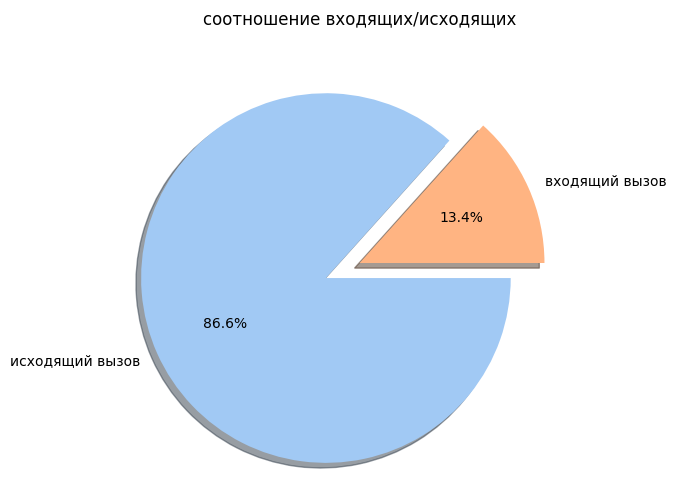

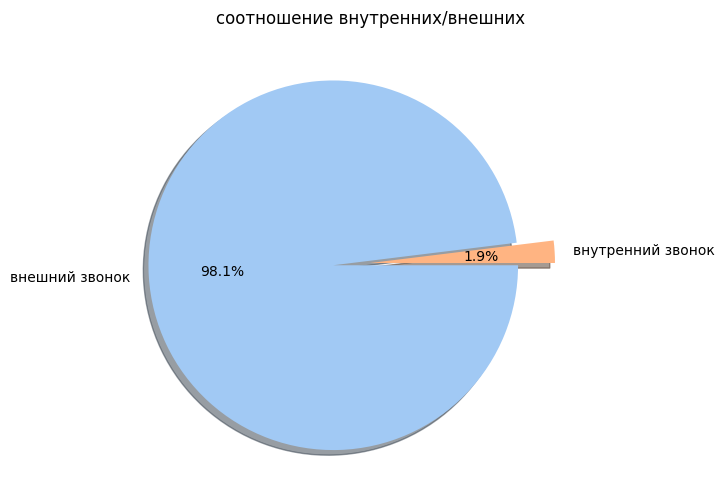

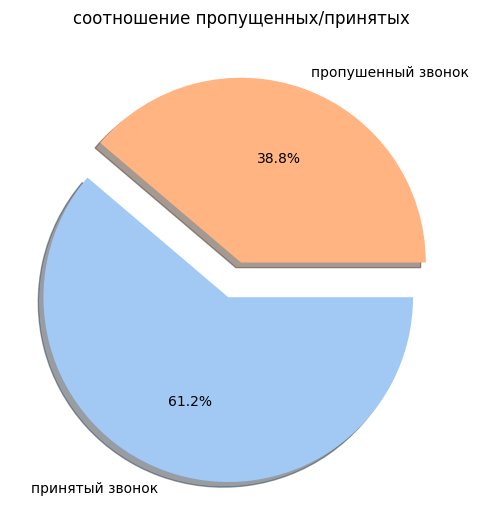

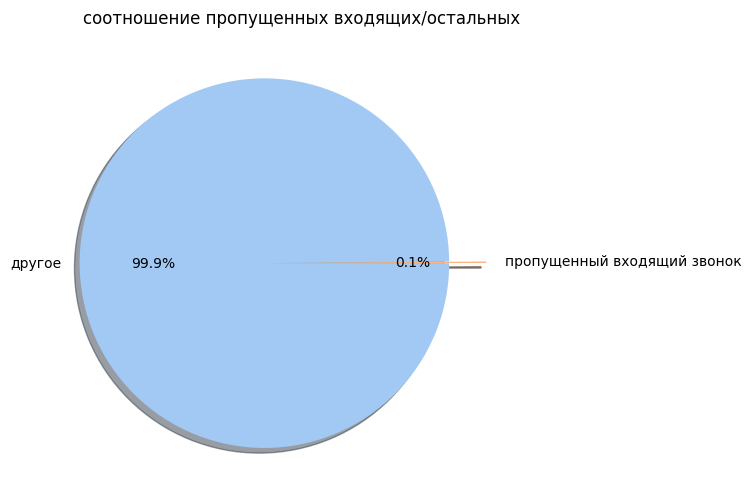

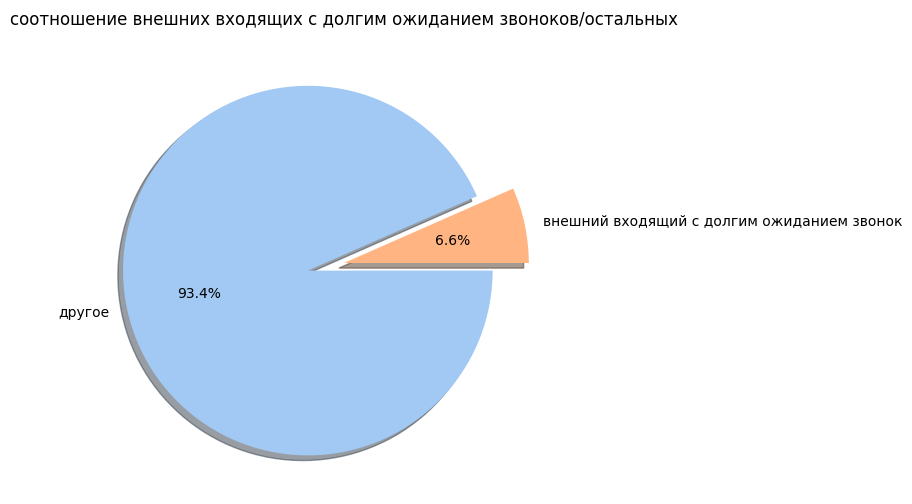

In [7]:
# рассмотрим булевые признаки
def make_group_table(grop_column: Union[str,list[str]],
                                        agg_column: str,
                                        agg_function: str,
                                        data: pd.DataFrame = data,
                                        sorting_column: str = '%') -> pd.DataFrame:
    """группирует по признаку/признкам"""
    if not isinstance(grop_column, list) and not isinstance(grop_column, str):
        raise TypeError('grop_column must be list or string')
    if not isinstance(agg_column, str):
        raise TypeError('agg_column must be string')
    if not isinstance(agg_function, str):
        raise TypeError('agg_function must be string')
    if not isinstance(data, pd.DataFrame):
        raise TypeError('data must be DataFrame')
    if isinstance(grop_column, list):
        for column in grop_column:
            if not validate(data, column):
                raise ValueError('column does not found')
            else:
                continue
    else:
        for column in [grop_column, agg_column]:
            if not validate(data, column):
                raise ValueError('column does not found')
            else:
                continue
    table: pd.DataFrame = (data
                               .groupby(by=grop_column)
                               .agg({agg_column: agg_function})
                               .reset_index()
                               .rename(columns={agg_column: f'{agg_column}_{agg_function}'}))
    table['%']: pd.Series = round((table[
                                         f'{agg_column}_{agg_function}'
                                        ] / sum(table[
                                                      f'{agg_column}_{agg_function}'
                                                     ])) * 100, 2)
    return table.sort_values(by=sorting_column, ascending=False).reset_index(drop=True)

def make_pieplot(group_column: str,
                 agg_column: str,
                 agg_function: str,
                 params: dict[bool: str],
                 title: str,
                 data: pd.DataFrame = data) -> None:
    sns.set_palette('pastel')
    plt.figure(figsize=(6, 6))
    explode: tuple[Union[int, float]] = (0.2, 0)
    df: pd.DataFrame = make_group_table(group_column, agg_column, agg_function, data)
    plt.pie(df[f'{agg_column}_{agg_function}'],
            labels=df[group_column].map(params), 
            explode=explode, 
            autopct='%1.1f%%', 
            counterclock=False, 
            shadow=True)
    plt.title(title)
    plt.show();


    
def make_fast_analis(data: pd.DataFrame=data) -> None:
    for column, params, title in zip(['dir_sup', 'internal',
                                      'is_missed_call', 'miss_in',
                                      'long_waiting_in_int'],
                                     [{True: 'входящий вызов',
                                       False: 'исходящий вызов'},
                                      {True: 'внутренний звонок',
                                       False: 'внешний звонок'},
                                      {True: 'пропушенный звонок',
                                       False: 'принятый звонок'},
                                      {True: 'пропущенный входящий звонок',
                                       False: 'другое'}, 
                                      {True: 'внешний входящий с долгим ожиданием звонок',
                                       False: 'другое'}],
                                     ["соотношение входящих/исходящих",
                                      "соотношение внутренних/внешних", 
                                      "соотношение пропущенных/принятых",
                                      "соотношение пропущенных входящих/остальных",
                                      "соотношение внешних входящих с долгим ожиданием звоноков/остальных"]):
        make_pieplot(column, 'calls_count', 'sum', params, title, data)

make_fast_analis()


In [8]:
# удалим пропущенные вызовы со временем разговора больше 0
# и принятые вызовы с 0 - так как объяснить такое явление сложно - неявная аномалия 

index: pd.DataFrame = (data
         .query('(is_missed_call == True and call_duration > 0) or (is_missed_call == False and call_duration == 0)')
         .index)

data = data.query('index not in @index')

In [9]:
class BoxMath:
    """Parents math class for anomalies"""

    CONSTANT: Optional[Union[int, float]] = None

    def __init__(self, df: pd.DataFrame, column: str) -> None:
        """
        инициализация
        """
        self.df = df
        self.column = column
        if self.column  not in set(self.df.columns):
            raise ValueError('ошибка при формировании класса')
        if self.df[self.column].isna().sum() > 0:
            self.df = self.df[self.df[self.column].notna()]
            logging.info('были исключены пропуски')

    @property
    def metrics(self) -> dict[str: Union[int, float]]:
        """
        Рассчитываем показатели:
        необходмые для вычислений
        """
        pass

    @property
    def max_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет верхнюю границу усов
        """
        pass

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет нижнюю границу усов
        """
        pass

    def is_distribution_normal(self, alpha: float = 0.05)-> bool:
        """определяет нормальное ли распределение"""
        if sst.shapiro(self.df[self.column])[1] < alpha:
            return False 
        return True
    
    @property
    def anomalies(self) -> pd.Series:
        """
        аномальные значения
        """
        return (self.df[
                        (self.df[self.column] < self.min_not_anomal)
                          | 
                        (self.df[self.column] > self.max_not_anomal)
                        ][self.column])
    
    @property
    def anomalies_indexs(self) -> pd.Series:
        """Возращает индексы аномальных строк"""
        return self.anomalies.index


class BoxIQR(BoxMath):
    """
    Класс содержит анализ по выбросам
    """

    CONSTANT: float = 1.5

    @property
    def metrics(self) -> dict[str: Union[int, float]]:
        """
        Рассчитываем показатели:
        -второй квартиль
        -третий квартиль
        -межквартильный размах
        """
        q75, q25 = np.percentile(self.df[self.column], [75 ,25])
        metrics: dict[str: float] = {'iqr': q75 - q25,
                                     'q75': q75,
                                     'q25': q25}
        return metrics
    
    @property
    def max_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет верхнюю границу усов
        """
        max_not_anomal: float = self.metrics['q75'] + self.CONSTANT * self.metrics['iqr']
        if (max_not_anomal > self.df[self.column].max()):
            return self.df[self.column].max()
        else:
            return max_not_anomal

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """
        Вычисляет нижнюю границу усов
        """
        min_not_anomal: float = self.metrics['q25'] - self.CONSTANT * self.metrics['iqr']
        if min_not_anomal < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anomal
    
    @property
    def min_p_anom(self) -> Union[int, float]:
        """минималльный положительный выброс по доходности"""
        return self.anomalies[self.anomalies > 0].min()


class BoxSTD(BoxMath):
    """Считает выбросы в нормальном распределении"""
    CONSTANT: int = 3 

    @property
    def metrics(self)->dict[str:Union[int, float]]:
        """возращает стандартное отклонение и среднее"""
        return {'std': self.df[self.column].std(),
                'mean': self.df[self.column].mean()}
    
    @property
    def max_not_anomal(self) -> Union[int, float]:
        """Возвращает верхнюю границу"""
        max_not_anomal: float = self.metrics['mean'] + self.CONSTANT * self.metrics['std']
        if max_not_anomal > self.df[self.column].max():
            return self.df[self.column].max()
        else:
            return max_not_anomal

    @property
    def min_not_anomal(self) -> Union[int, float]:
        """Возвращает нижнюю границу"""
        min_not_anomal: float = self.metrics['mean'] - self.CONSTANT * self.metrics['std']
        if min_not_anomal < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anomal


class BoxVisualisation:
    """
    Строим графики к выбросам
    """

    def __init__(self, math_object: BoxMath, level: Optional[str] = None) -> None:
        """инициализация"""
        self.math_object = math_object
        self.level = level
        if self.level is not None and isinstance(self.level, str):
            self.rank = self.math_object.df.groupby(self.level)[self.math_object.column].median().fillna(0).sort_values()[::-1].index
        elif self.level is not None and not isinstance(self.level, str):
            raise TypeError('suplements parametr must be str')
        elif self.level is not None and self.level not in set(self.math_object.df.columns):
            raise TypeError('column not found - 404')
    
    def represent_violinplot(self, plots_size: tuple[int] = (15, 15)) -> None:
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title("Violin plot", loc="left")
        if self.level is not None:
            sns.violinplot(x=self.math_object.df[self.math_object.column],
                           y=self.math_object.df[self.level])
        else:
            sns.violinplot(x=self.math_object.df[self.math_object.column])
        plt.show()

    def represent_box(self, plots_size: tuple[int] = (15, 15)) -> None:
        """выводит бокс-плот"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Бокс-плот')
        if self.level is not None:
            sns.boxplot(x=self.math_object.df[self.math_object.column],
                        y=self.math_object.df[self.level],
                        order=self.rank, color='mediumpurple')
        else:
            sns.boxplot(x=self.math_object.df[self.math_object.column])
        plt.show();

    def represent_in_detail(self, plots_size: tuple[int] = (15, 15)) -> None:
        """приближенный бокс-плот"""
        
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Приближенный бокс-плот')
        if self.level is not None:
            sns.boxplot(x=self.math_object.df[self.math_object.column],
                        y=self.math_object.df[self.level],
                        order=self.rank, color='mediumpurple').set_xlim([self.math_object.min_not_anomal, 
                        self.math_object.max_not_anomal])
        else:
            sns.boxplot(x=self.math_object.df[self.math_object.column]).set_xlim([self.math_object.min_not_anomal,
                                                                                   self.math_object.max_not_anomal])
        plt.show();


        
    def represent_scatter(self, plots_size: tuple[int] = (20, 20)) -> None:
        """"выводит точечный график"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        plt.title('Точечный график')
        if self.level is not None:
            sns.scatterplot(x=self.math_object.df.index,
                            y=self.math_object.df[self.math_object.column],
                            hue=self.math_object.df[self.level])
        else:
            sns.scatterplot(x=self.math_object.df.index,
                            y=self.math_object.df[self.math_object.column])
        plt.axhline(y=self.math_object.max_not_anomal,
                        color='red',
                        linestyle='dotted',
                        label='Максимальное значение без выбросов')
        plt.axhline(y=self.math_object.min_not_anomal,
                        color='red',
                        linestyle='dotted',
                        label='Минимальное значение без выбросов')
        plt.axhline(y=self.math_object.df[self.math_object.column].median(),
                        color='green',
                        linestyle='--',
                        label='Медиана')
        plt.axhline(y=self.math_object.df[self.math_object.column].mean(),
                        color='pink',
                        linestyle='--',
                        label='Среднее значение')
        plt.legend()
        plt.show();

    def represent_histplot(self, plots_size: tuple = (15, 15)) -> None:
        """распределение с выбросами"""
        sns.set_palette('dark')
        plt.figure(figsize=plots_size)
        sns.kdeplot(self.math_object.df[self.math_object.column])
        plt.axvline(x=self.math_object.df[self.math_object.column].mean(), color='green', linestyle='--', label='Среднее значение')
        plt.axvline(x=self.math_object.min_not_anomal, color='orange', linestyle=':', label='Минимальное значение без выбросов')
        plt.axvline(x=self.math_object.max_not_anomal, color='orange', linestyle=':', label='Максимальное значение без выбросов')
        plt.title('гистограмма')
        plt.legend()
        plt.show();


@dataclass
class PrinterReport:
    """Выводим отчет"""

    math_object: BoxMath
    visual_object: BoxVisualisation
    visualisations = {'boxplot': 'represent_box',
                      'detail_box_plot': 'represent_in_detail',
                      'scatterplot': 'represent_scatter',
                      'violinplot': 'represent_violinplot',
                      'histplot': 'represent_histplot'}
    
    def print_result(self) -> None:
        
        @widgets.interact(graphs=self.visualisations.keys())
        def plot_graphs(graphs):
            getattr(self.visual_object, self.visualisations[graphs])()
            plt.show()

        for metric, value in self.math_object.metrics.items():
            print(f'{metric} - {value}')
        print(f"минимальное неаномальное значение {self.math_object.min_not_anomal} \n"
              f"максимальное неаномальное значение {self.math_object.max_not_anomal}")
        print('выбросов % - ', round((len(self.math_object.anomalies) / len( self.math_object.df)) * 100, 2))

        button = widgets.Button(description="Узнать больше!", 
                                button_style='info')
        def on_button_clicked(b):
            display(pd.DataFrame({'anomalies': self.math_object.anomalies,
                                  'index': self.math_object.anomalies_indexs}))
        button.on_click(on_button_clicked)
        display(button)
        
        
def is_distribution_normal(data: pd.Series, alpha: float = .05) -> bool:
    """определяет нормальное ли распределение"""
    if sst.shapiro(data)[1] < alpha:
        return False 
    return True



def make_full_analyses_anomalies(data: pd.DataFrame, column: str, factor: Optional[pd.Series] = None) -> None:
    if is_distribution_normal(data[column]):
        math: BoxMath = BoxSTD(data, column)
    else:
        math: BoxMath = BoxIQR(data, column)
    visualisation: BoxVisualisation = BoxVisualisation(math, factor)
    report: PrinterReport = PrinterReport(math, visualisation)
    report.print_result()

In [10]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [11]:
# проведем анализ числовых признаков
# в factors - можно натыкать признак
# в graphs - можно выбрать график


@widgets.interact(factors=NUMERICAL_COLUMNS)
def plot_anal(factors):
    make_full_analyses_anomalies(data, factors)


interactive(children=(Dropdown(description='factors', options=('calls_count', 'call_duration', 'total_call_dur…

In [12]:
# посмотри распределение операторов по центрам
# в graphs - можно выбрать график - рекомендую гистограмму к этому случаю
make_full_analyses_anomalies(make_group_table('user_id',
                                              "operator_id",
                                              "nunique"),
                             'operator_id_nunique')

interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 3.0
q75 - 4.0
q25 - 1.0
минимальное неаномальное значение 1 
максимальное неаномальное значение 8.5
выбросов % -  7.24


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

In [13]:
# посмотрим на корреляцию признаков
# достаточно большие данные - кнопки могут виснуть - надо немного подождать и все будет
# на graphs - либо table-табличное представление - рекомендуемый тип либо plot - график регресии
# predictors - фичи, числовые колонки
# targets - предсказываемое значение, числовые колонки

class Regressor:
    """Класс линейной регрессии""" 
 
    def __init__(self, data, predictor, target, text): 
        self.data = data 
        self.predictor = predictor 
        self.target = target 
        self.text = text
        if self.data[self.predictor].isna().sum() > 0:
            self.data = self.data[self.data[self.predictor].notna()]
            logging.info('были исключены пропуски')
        if self.data[self.target].isna().sum() > 0:
            self.data = self.data[self.data[self.target].notna()]
            logging.info('были исключены пропуски')
 
    def analysis(self): 
        if self.predictor in self.data.columns and self.target in self.data.columns: 
            regression = sm.OLS(self.data[self.predictor], sm.add_constant(self.data[self.target])) 
            result = regression.fit() 
            return {
                'params': result.params,
                'bse': result.bse,
                'pvalues': result.pvalues,
                't_test_const': result.t_test([1,0]),
                't_test_regr': result.t_test([0,1]),
                'f_test': result.f_test(np.identity(2)),
                'summary': result.summary()
            }
        else:
            raise ValueError('Столбцы predictor и/или target не найдены в датафрейме')
 
    def get_plot(self, savefig=None): 
        if self.predictor in self.data.columns and self.target in self.data.columns:
            sns.set_style("whitegrid") 
            sns.set_palette("husl") 
            plt.figure(figsize=(10, 6)) 
            plot = sns.jointplot(x=self.predictor, y=self.target, data=self.data, kind='reg') 
            plot.fig.suptitle(self.text[0], x=1.15, y=1.05, fontsize=16) 
            plot.set_axis_labels(self.text[1], self.text[2], fontsize=12) 
            if savefig is not None:
                plt.savefig(savefig)
            plt.show();
        else:
            raise ValueError('Столбцы predictor и/или target не найдены в датафрейме')

    def get_table(self):
        display(self.analysis()['summary'])

class ReportReg:
    def __init__(self, data, columns):
        self.data = data
        self.columns = columns
        self.methods = {'table': 'get_table', 'plot': 'get_plot'}
        self.graphs = ['table', 'plot']
        
    def get_report(self):
        @widgets.interact(graphs=self.graphs, predictors=self.columns, targets=self.columns)
        def get_reg_anal(graphs, predictors, targets):
            reg = Regressor(self.data, predictors, targets, [f'Взаимосвязь {predictors} и {targets}', predictors, targets])
            getattr(reg, self.methods[graphs])()
    
report = ReportReg(data, NUMERICAL_COLUMNS)
report.get_report()


interactive(children=(Dropdown(description='graphs', options=('table', 'plot'), value='table'), Dropdown(descr…

Вывод:
- болльшинство звонков исходящие, внешние;
- соотношение принятых и пропущенных печально 61 к 31 соответственно;
- очень малая доля пропущенных входящих звонков всего 0,1% от общего числа звонков;
- внешние входящие с долгим ожиданием - 6,6% от общего кол-ва звонков;
- данные зашумлены, в среднем выбросы по признакам 12%;
- операторы по колл-центрам распределены неравномерно;
- из-за специфики генерации признаков - доля коллениарны.

всего пропущенных: 13814, пропущенных входящих: 410, пропущенных исходящих: 13404


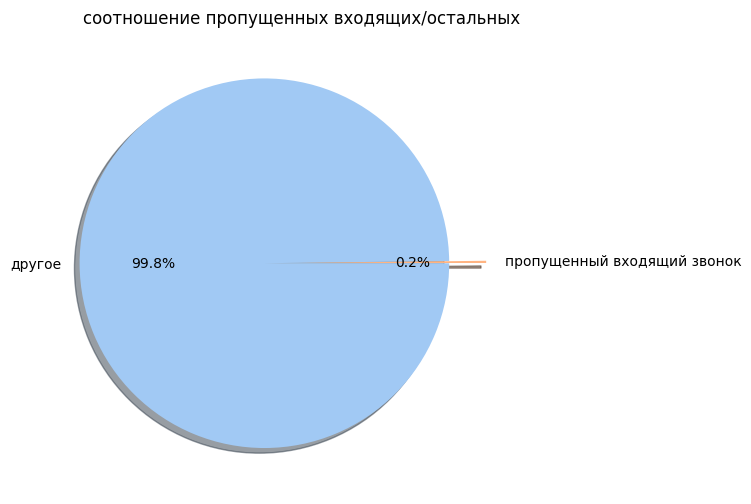

In [14]:
m_c = data.query('is_missed_call == True')
print('всего пропущенных: {}, пропущенных входящих: {}, пропущенных исходящих: {}'.format(len(m_c), len(m_c.query('direction == "in"')), len(m_c.query('direction == "out"'))))
make_pieplot('miss_in',
             'calls_count',
             'sum',
             {True: 'пропущенный входящий звонок',
              False: 'другое'},
             "соотношение пропущенных входящих/остальных",
             data.query('is_missed_call == True'))

## Определение неэффективных операторов

In [15]:
# так как искать неэффективность нужно в рядах операторов сгруппируем данные по operator_id
# все данные не нужны, оставим только интересные признаки, которые не будут зашулять модельки
# так как шум в данных мы обнаружили, то численные признаки будем агрегировать по медиане, булевые по среднему

df: pd.DataFrame = (data[['operator_id',
                         'is_missed_call', 'calls_count',
                         'avg_speak_time', 
                         'waiting_time_per_call_duration',
                         'avg_speak_time_per_call_duration',
                         'miss_in', 'long_waiting_in_int']]
    .groupby(by='operator_id')
    .agg({'is_missed_call': 'mean',
          'calls_count': 'median',
          'avg_speak_time': 'median',
          'waiting_time_per_call_duration': 'median',
          'avg_speak_time_per_call_duration': 'median',
          'miss_in': 'mean',
          'long_waiting_in_int': 'mean'}))

FEATURES: list = ['is_missed_call', 'calls_count',
                  'avg_speak_time', 
                  'waiting_time_per_call_duration',
                  'avg_speak_time_per_call_duration',
                  'miss_in', 'long_waiting_in_int']

In [16]:
class Cluster:
    """Класс для кластеризации данных"""

    def __init__(self, columns: list[str], data: pd.DataFrame, n_max: int = 5) -> None:
        """Инициализация."""
        self.data = data
        self.columns = columns
        self.x: pd.DataFrame = self.data[self.columns]
        self.scaler = StandardScaler()
        self.scaler.fit(self.x)
        self.x_st = self.scaler.transform(self.x)
        self.n_max = n_max
        self.K = range(2, self.n_max)
        self.score: list = []

    def get_dendrogram(self, percent: float = 0.05) -> None:
        """Строим дендограмму для оценки оптимальноко кол-ва кластеров."""
        df: pd.DataFrame = pd.DataFrame(self.x_st, columns=self.columns).sample(frac=percent)
        linked = linkage(df, method='ward')
        plt.figure(figsize=(15, 10))
        dendrogram(linked, orientation='top')
        plt.title('Hierarchical clustering')
        plt.show()
    
    @property
    def eblow_score(self) -> list[Union[int, float]]:
        """Зашумление данных по методу локтя."""
        distortions: list = []
        for k in self.K:
            km = KMeans(n_clusters=k)
            km.fit(self.x_st)
            distortions.append(km.inertia_)
        return distortions
        

    def get_eblow(self) -> None:
        """Визуализируем метод локтя."""
        plt.figure(figsize=(16,8))
        plt.plot(self.K, self.eblow_score, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method showing the optimal k')
        plt.show();

    @property
    def silhouette_scores(self) -> list[Union[int, float]]:
        """
        Коэффициенты по методу силуэта от 0-1
        1 - высокая точность модели
        0 - отсутствие точности модели.
        """
        for k in self.K:
            km = KMeans(n_clusters=k)
            labels = km.fit_predict(self.x_st)
            self.score.append(silhouette_score(self.x_st, labels))
        return self.score

    def get_silhouette_score(self) -> None:
        """Визуализация метода силуэта."""
        plt.figure(figsize=(16,8))
        if len(self.score) == 0:
            plt.plot(self.K, self.silhouette_scores, 'bx-')
        else:
            plt.plot(self.K, self.score, 'bx-')
        plt.xlabel('k')
        plt.ylabel('silhouette_score')
        plt.title('The Silhouette Method showing the optimal k')
        plt.show();

    @property
    def optimal_k(self):
        """
        Возвращает оптимальное кол-во ксластеров
        по методу силуэта как более точного метода.
        """
        if len(self.score) == 0:
            return sorted(list(zip(self.K, self.silhouette_scores)), key=lambda x: x[1], reverse=True)[0][0]
        else:
            return sorted(list(zip(self.K, self.score)), key=lambda x: x[1], reverse=True)[0][0]


    def cluster(self, k: Optional[int] = None) -> list[float]:
        """Возвращает предсказания для модельки ближайших соседей"""
        if k is None:
            km = KMeans(n_clusters=self.optimal_k, random_state=0)
        else:
            km = KMeans(n_clusters=k, random_state=0)
        return km.fit_predict(self.x_st)

    def show_clusters_on_plot(self, x_name, y_name,
                              k, cluster_name='cluster') -> None:
        """Отрисовывает распределение признаков по кластеру"""
        self.data['cluster'] = self.cluster(k)
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x=self.data[x_name], y=self.data[y_name],
                        hue=self.data[cluster_name], palette='Paired')
        plt.title('{} vs {}'.format(x_name, y_name))
        plt.show()
    
    def plot(self) -> None:
        """Рисуем все графики"""
        col_pairs: list = list(itertools.combinations(self.columns, 2))
        for pair in col_pairs:
            self.show_clusters_on_plot(pair[0], pair[1], 'cluster')


@dataclass
class ClusterReport:
    """Класс печатает отчет по модели Cluster."""

    cluster_object: Cluster
    attrs_score = {'eblow': 'get_eblow',
                   'silhouette':'get_silhouette_score',
                   'dendrogram':'get_dendrogram'}
    
    
    def print_report(self)-> None:
        """Отрисовывает распределение фичей по кластерам."""
        widgets.interact(self.cluster_object.show_clusters_on_plot, x_name=widgets.Dropdown(options=self.cluster_object.columns, description="Select x"),
                                                                    y_name=widgets.Dropdown(options=self.cluster_object.columns, description="Select y"),
                                                                    k=widgets.IntSlider(min=2, max=100, value=self.cluster_object.optimal_k, step=1, description="k"))
        
        @widgets.interact(types_score = self.attrs_score.keys())
        def plot_score(types_score):
            getattr(self.cluster_object, self.attrs_score[types_score])()

In [17]:
# попробуем разметить наших операторов по кластерам
# передадим колонки признаки и фрейм в Cluster - там небольшая магия
# Построиоли небольшой дашбордик где:
# x, y - фичи распределенные по кластерам - признаки можно натыкать
# k - число кластеров - по умолчанию стоит оптимальный, у которого наибольший коэффициент силуэта
# cluster_name - название новой колонки, которую Cluster положил в наш датасет
# types_score - выбор метода оценки - рекомендуемый силует - можно:
# eblow(метод локтя), silhouette(метод силуета), dendogram (я бы не ключал, но раз практикум рекомендует) 

cluster: Cluster = Cluster(FEATURES, df, 50)
report: ClusterReport = ClusterReport(cluster)
report.print_report()

interactive(children=(Dropdown(description='Select x', options=('is_missed_call', 'calls_count', 'avg_speak_ti…

interactive(children=(Dropdown(description='types_score', options=('eblow', 'silhouette', 'dendrogram'), value…

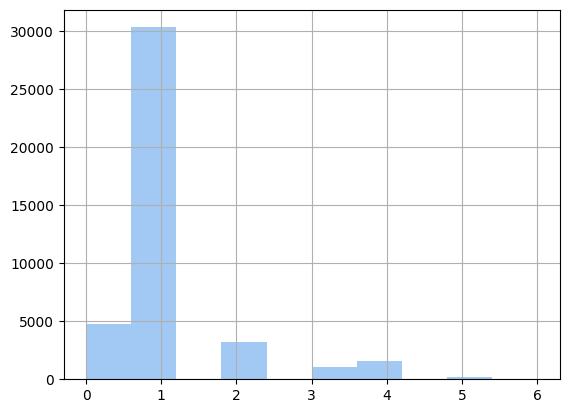

In [18]:
df = df.reset_index()
df_1 = data.set_index('operator_id').join(df[['operator_id','cluster']].set_index('operator_id'))

def fast_check():
    for pair in list(itertools.combinations([_ for _ in range(cluster.optimal_k)], 2)):
        indexs=df_1.query(f"cluster=={pair[0]}").index
        if len(df_1.query(f"cluster=={pair[1]} and index in @indexs")) == 0:
            continue
        else:
            raise BaseException('пересечение класторов')

# fast_check()
df_1['cluster'].hist()
plt.show();

In [19]:
# теперь нужно понять какой кластер считать неэффективным лузером,
# для этого воспользуемся модельками классификации, где ответами будут кластеры

class Classifier:
    """Класс классификации"""

    def __init__(self, cluster: Cluster) -> None:
        """Инициализация, все необходимое возьмем из Cluster"""
        self.cluster = cluster
        self.x = self.cluster.x_st
        self.y = self.cluster.cluster()
        (self.x_train, self.x_test,
         self.y_train, self.y_test) = train_test_split(self.x,
                                                       self.y,
                                                       test_size=0.2,
                                                       random_state=0)
             
    def logistic_regression(self) -> tuple[list[Union[int, float]],
                                           Optional[list[Union[int, float]]],
                                           pd.DataFrame]:
        """Сюда положим логистическую регрессию."""
        model = LogisticRegression(solver='liblinear')
        model.fit(self.x_train, self.y_train)
        predictions = model.predict(self.x_test)
        if self.cluster.optimal_k == 2:
            probabilities: list = model.predict_proba(self.x_test)[:,1]
        else:
            probabilities = None
        coeff_cluster = {f'coeff_cluster_{i}': model.coef_[i] for i in range(self.cluster.optimal_k)}
        coeff_cluster['feature'] = self.cluster.columns
        coeff = pd.DataFrame(data=coeff_cluster)
        return predictions, probabilities, coeff

    def tree_classifier(self) -> tuple[list[Union[int, float]],
                                           Optional[list[Union[int, float]]],
                                           pd.DataFrame]:
        """Сдесь модель решающего дерева."""
        tree_model = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
        tree_model.fit(self.x_train, self.y_train)
        tree_predictions = tree_model.predict(self.x_test)
        if self.cluster.optimal_k == 2:
            tree_probabilities = tree_model.predict_proba(self.x_test)[:, 1]
        else:
            tree_probabilities = None
        return tree_predictions, tree_probabilities, tree_model
    
    def plot_model(self, model) -> None:
        """Отрисовываем модельки."""
        if model == 'reg':
            _, _, coeff = self.logistic_regression()
            display(coeff.style.background_gradient('coolwarm'))
        else:
            _, _, tree_model = self.tree_classifier()
            plt.figure(figsize = (25,20))
            tree.plot_tree(tree_model,
                           filled=True,
                           feature_names = self.cluster.columns,
                           class_names = [f'cluster_{i}' for i in range(self.cluster.optimal_k)])
            plt.show();
            

    def metrics(self, model: str) -> pd.DataFrame:
        """Посмотри на качество моделек."""
        if model == 'reg':
            predictions, probabilities, _ = self.logistic_regression()
        else:
            predictions, probabilities, _ = self.tree_classifier()
        if self.cluster.optimal_k == 2:
            df = pd.DataFrame({'metric':['Accuracy', 'Precision',
                                            'Recall', 'F1', 'ROC_AUC'],
                                    'coeff':[accuracy_score(self.y_test, predictions),
                                    precision_score(self.y_test, predictions),
                                    recall_score(self.y_test, predictions),
                                    f1_score(self.y_test, predictions),
                                    roc_auc_score(self.y_test, probabilities)
                                            ]}).style.background_gradient('coolwarm')
        else:
            df = pd.DataFrame({'metric':['Accuracy', 'Precision',
                                            'Recall', 'F1'],
                                    'coeff':[accuracy_score(self.y_test, predictions),
                                    precision_score(self.y_test, predictions, average='micro'),
                                    recall_score(self.y_test, predictions, average='micro'),
                                    f1_score(self.y_test, predictions, average='micro')
                                            ]}).style.background_gradient('coolwarm')
            
        return df



klass: Classifier = Classifier(cluster)

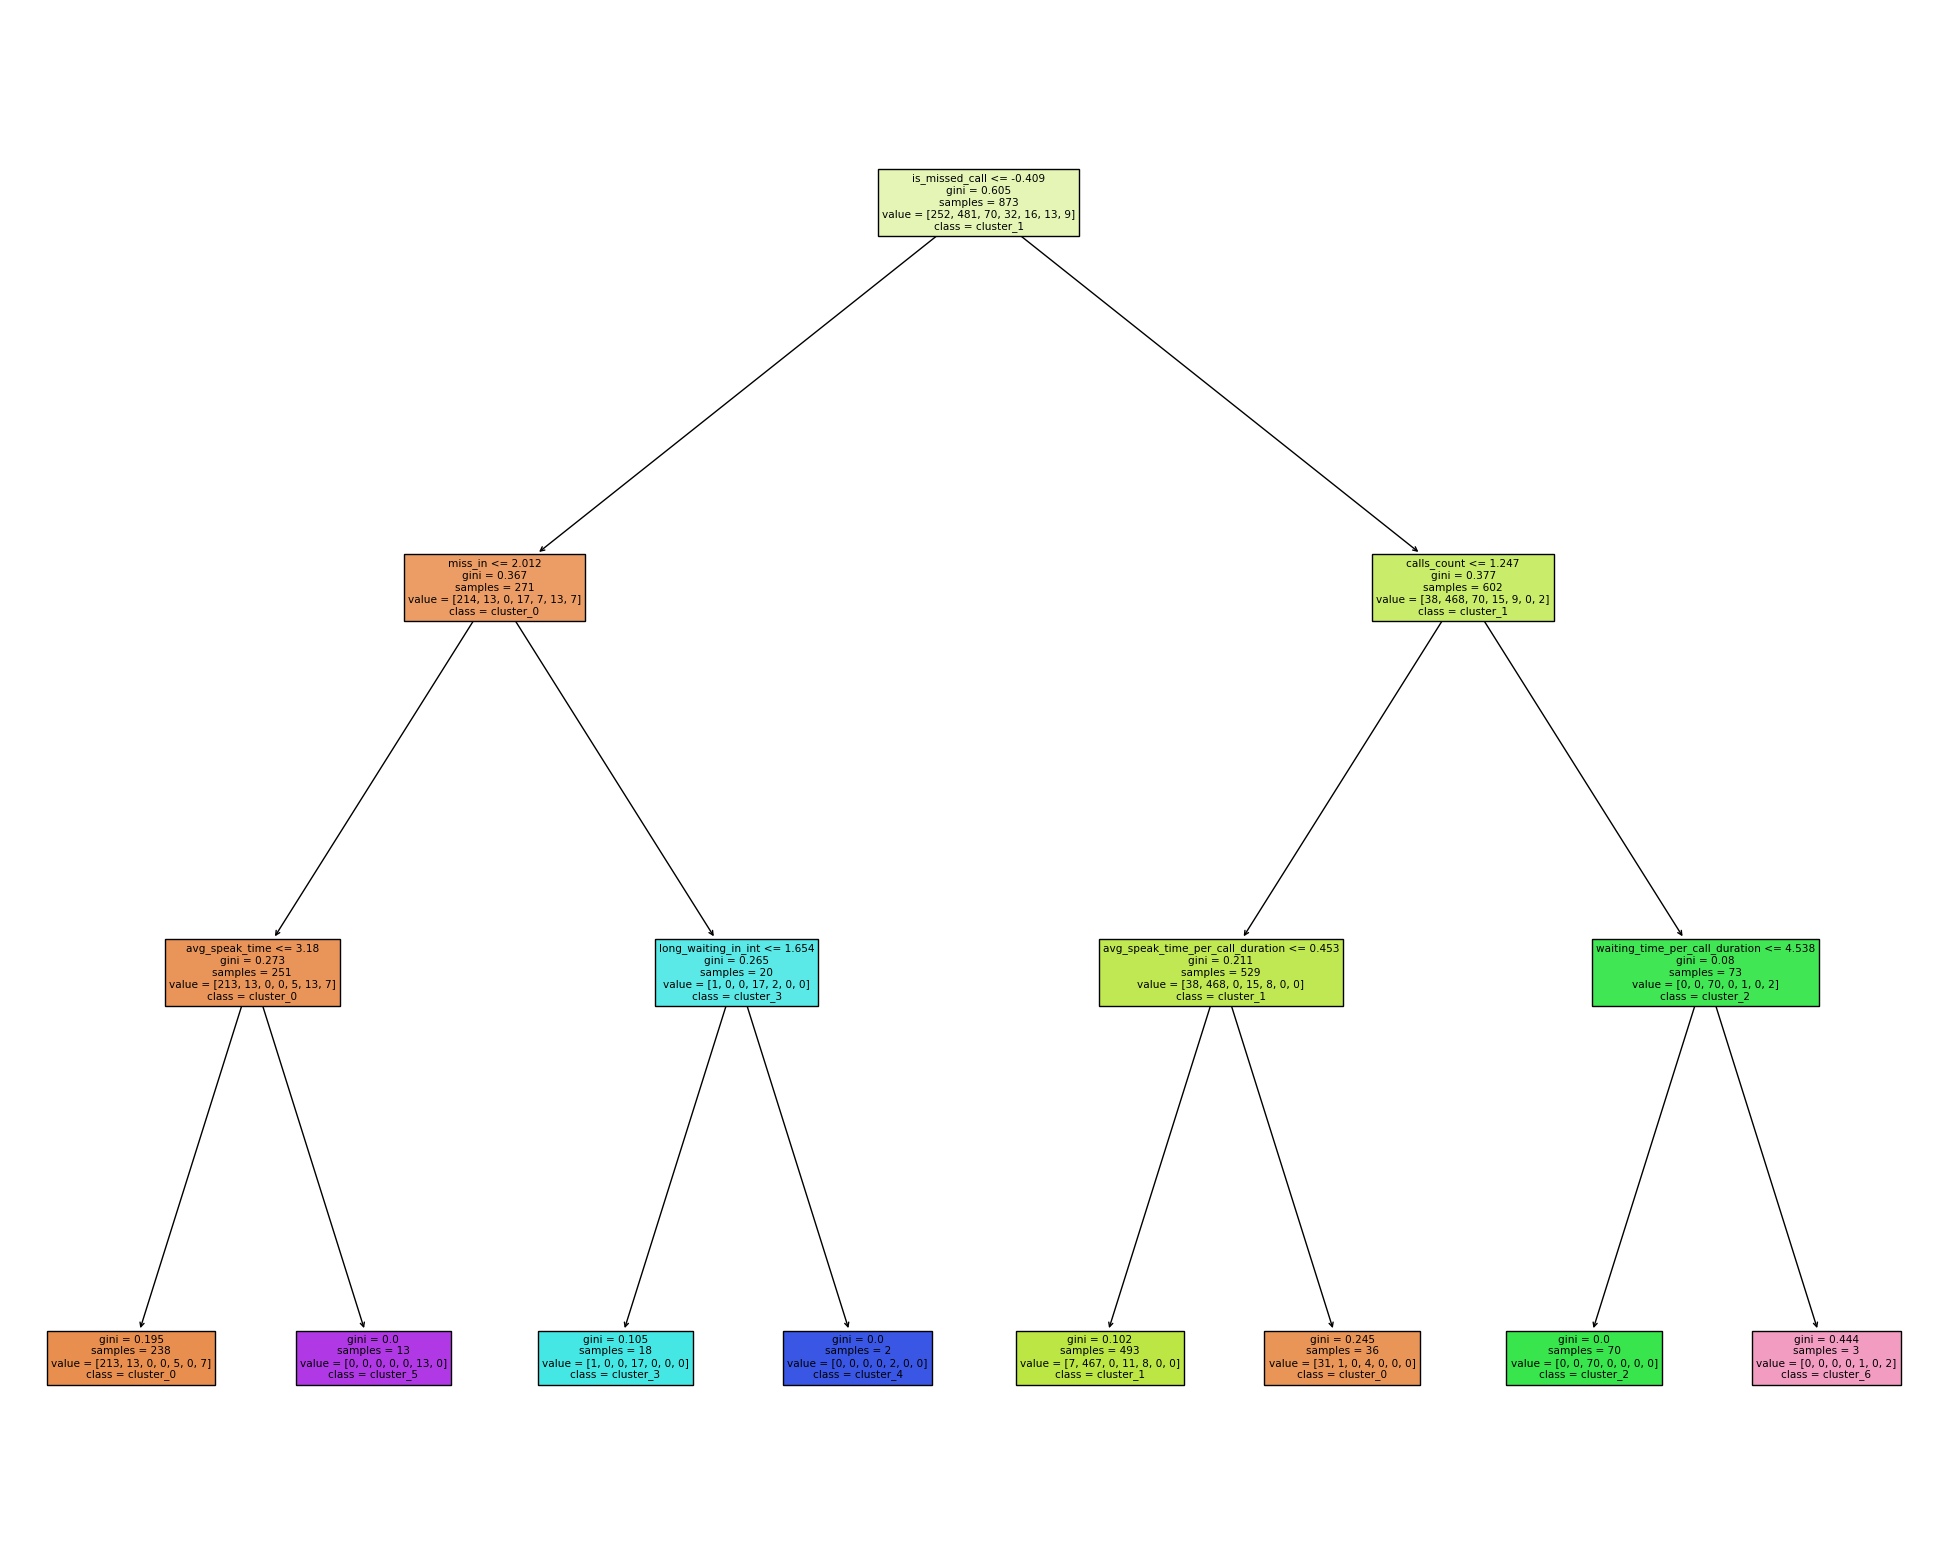

In [20]:
klass.plot_model('tree')
klass.metrics('tree')

In [21]:
klass.plot_model('reg')
klass.metrics('reg')


In [22]:
# проведем ранжирование кластеров по признакам

_, _, cf_rl = klass.logistic_regression()
d = cf_rl.melt(id_vars='feature', var_name='cluster', value_name='coeff')
dd = {}
for feature in d['feature'].unique():
    ddd = d.query('feature == @feature')
    dd[feature] = [[cluster, ddd.query('cluster == @cluster')['coeff'].values[0]] for cluster in d['cluster'].unique()]

for i in ['is_missed_call', 'waiting_time_per_call_duration','miss_in', 'long_waiting_in_int']:
    dd[i] = sorted(dd[i],
                     key=lambda x: x[1],
                   reverse=True)
for i in ['calls_count', 'avg_speak_time', 'avg_speak_time_per_call_duration']:
    dd[i] = sorted(dd[i],
                     key=lambda x: x[1])

for _, l in dd.items():
    for idx, _ in enumerate(l) :
        _.append(idx+1)
f = {}
for _, l in dd.items():
    for x in l:
        if x[0] not in f:
            f[x[0]] = [x[2]]
        else:
            f[x[0]].append(x[2])
for _, l in f.items():
    f[_] = sum(l)/len(l)
print(sorted(tuple(f), key=lambda x: x[1])[0])

coeff_cluster_1


Вывод:

Выберем лузеров. По нашим признакам неэффективность операторов можно описать так:
- у них много пропущенных звонков
- они обрабатывают малое кол-во звонков
- у них длительное время ожидания ответа
- незначительное время среднего разговора
- у них много пропущенных входящих звонков
- у них длительное ожидание ответа при входящих внешних вызовах

В моем представлении, кластер должен отвечать требованиям:
- коэффициент при `is_missed_call` должен быть положительным и максимально большим
- коэффициент при `calls_count` отрицательным, минимальным
- коэффициент при `waiting_time_per_call_duration` положительным, максимальным
- коэффициент при `avg_speak_time_per_call_duration` отрицательным, минимальным
- коэффициент при `miss_in` положительным, максимальным
- коэффициент при `long_waiting_in_int` положительным, максимальным


Наиболее подходящим под эти параметры оказался первый кластер


## Гипотезы:

In [23]:
# Проверим, что существует статическое значимое различие в средних между признаками кластера лузеров и остальных

def calc_hypoteses(data_1, data_2, alpha=0.05, equal_var=False):
    results = sst.ttest_ind(data_1,
                           data_2,
                           equal_var=equal_var)
    print('p-value: ', results.pvalue)
    if results.pvalue < alpha:
        display(widgets.HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>'))
    else:
        display(widgets.HTML(value='<b>Вывод:</b> <i>Не получилось отвергнуть нулевую гипотезу</i>'))

        
def anal_hyp(data_1, data_2, alpha=0.05):
    if is_distribution_normal(data_1) and  is_distribution_normal(data_2):
        print('Данные распределены нормально')
        calc_hypoteses(data_1, data_2, equal_var=True)
    calc_hypoteses(data_1, data_2)

for column in ['is_missed_call', 'calls_count',
       'avg_speak_time', 'waiting_time_per_call_duration',
       'avg_speak_time_per_call_duration', 'miss_in', 'long_waiting_in_int']:
    display(widgets.HTML(value=f"<h4>{column}:</h4>"))
    anal_hyp(df_1.query('cluster==1')[column], df_1.query('cluster!=3')[column])
#     print('*'*100)

HTML(value='<h4>is_missed_call:</h4>')

p-value:  1.0101641094300326e-14


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

HTML(value='<h4>calls_count:</h4>')

p-value:  2.2612271157305912e-123


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

HTML(value='<h4>avg_speak_time:</h4>')

p-value:  0.3900475657856526


HTML(value='<b>Вывод:</b> <i>Не получилось отвергнуть нулевую гипотезу</i>')

HTML(value='<h4>waiting_time_per_call_duration:</h4>')

p-value:  5.082794294151916e-79


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

HTML(value='<h4>avg_speak_time_per_call_duration:</h4>')

p-value:  6.277427227649776e-32


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

HTML(value='<h4>miss_in:</h4>')

p-value:  0.004541087068765791


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

HTML(value='<h4>long_waiting_in_int:</h4>')

p-value:  1.2011975287882837e-24


HTML(value='<b>Вывод:</b> <i>Отвергаем нулевую гипотезу</i>')

Вывод: по всем признакам, кроме `avg_speak_time` мы отвергли нулевую гипотезу о статистическом равенстве средних, что подтверждает правильность кластеризации.

In [24]:
# посмотрим на первый кластер

cluster_looser = df.query('cluster==1')
cluster_looser.describe()

operator_id  is_missed_call  calls_count  avg_speak_time  \
count     587.000000      587.000000   587.000000      587.000000   
mean   925165.441227        0.438410     6.192504       33.527844   
std     24131.980510        0.180404     7.298516       32.029284   
min    879896.000000        0.125000     1.000000        0.000000   
25%    904120.000000        0.327551     2.000000        6.583333   
50%    926312.000000        0.400000     3.000000       27.100000   
75%    943442.000000        0.500000     7.000000       52.621429   
max    973120.000000        1.000000    36.500000      216.557692   

       waiting_time_per_call_duration  avg_speak_time_per_call_duration  \
count                      587.000000                        587.000000   
mean                        31.239472                         14.376559   
std                         43.236607                         15.381116   
min                          0.000000                          0.000000   
25%                          3.077500                          2.485000   
50%                         16.360000                          8.330000   
75%                         39.730000                         25.000000   
max                        283.335000                         66.665000   

          miss_in  long_waiting_in_int  cluster  
count  587.000000           587.000000    587.0  
mean     0.003269             0.011513      1.0  
std      0.009157             0.038101      0.0  
min      0.000000             0.000000      1.0  
25%      0.000000             0.000000      1.0  
50%      0.000000             0.000000      1.0  
75%      0.000000             0.000000      1.0  
max      0.062500             0.241379      1.0

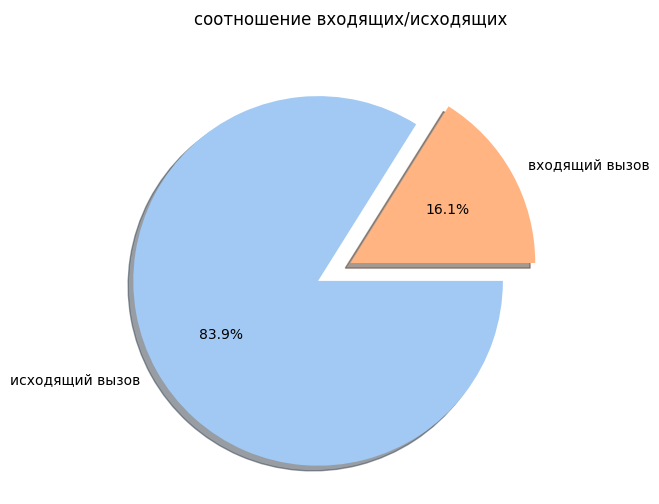

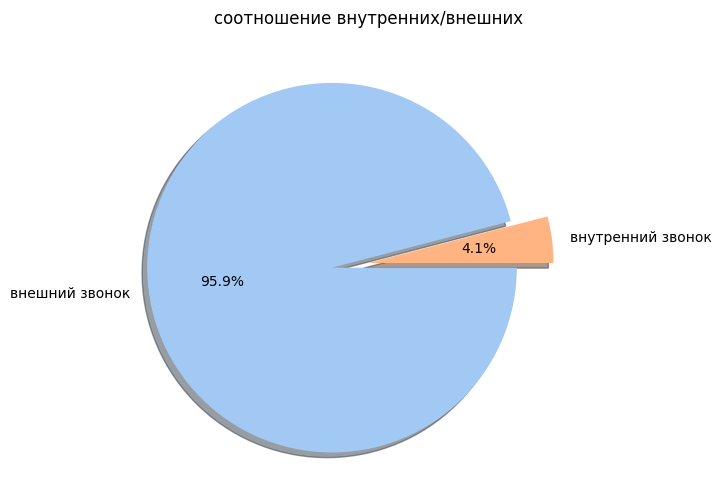

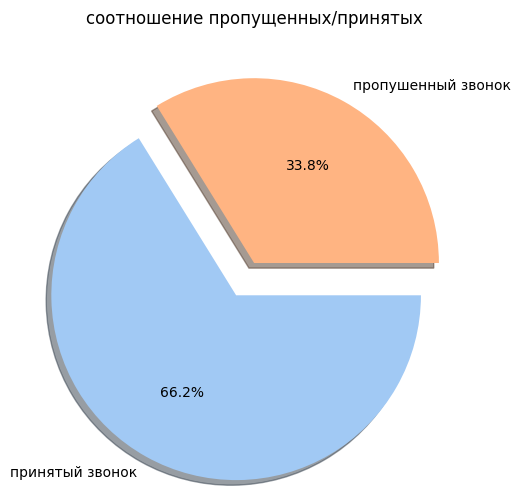

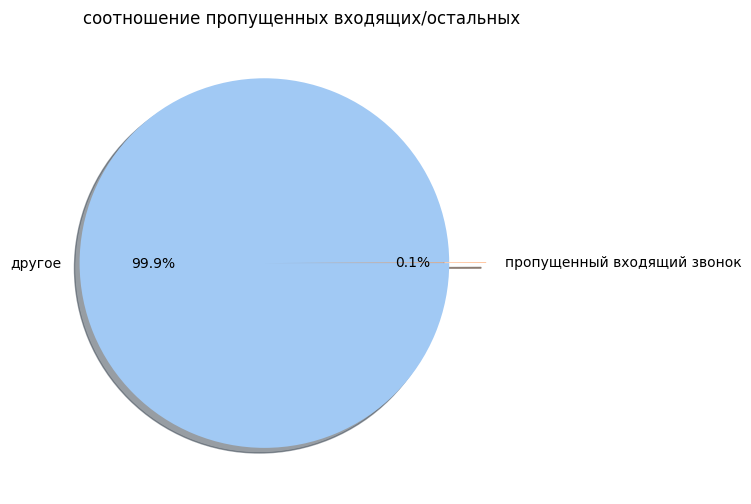

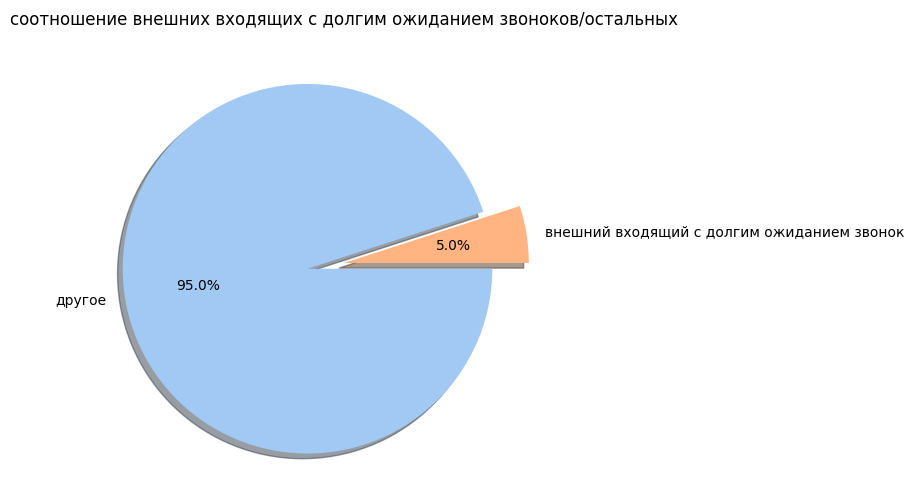

In [25]:
make_fast_analis(df_1.query('cluster==1'))

In [26]:
@widgets.interact(factors=NUMERICAL_COLUMNS)
def plot_anal(factors):
    make_full_analyses_anomalies(df_1.query('cluster==1'), factors)

interactive(children=(Dropdown(description='factors', options=('calls_count', 'call_duration', 'total_call_dur…

In [ ]:
# сравним кластеры
@widgets.interact(factors=NUMERICAL_COLUMNS)
def plot_anal(factors):
    make_full_analyses_anomalies(df_1, factors, 'cluster')

interactive(children=(Dropdown(description='factors', options=('calls_count', 'call_duration', 'total_call_dur…

## Вывод

В результате анализа данных, можно сделать следующие выводы:

1. Большинство звонков в данном наборе данных являются исходящими и внешними. Это означает, что компания активно звонит своим клиентам и внешним контактам.

2. Соотношение принятых и пропущенных звонков печально, так как пропущенных звонков значительно больше. Это может свидетельствовать о проблемах в организации обработки звонков или недостаточной эффективности операторов.

3. Очень малая доля пропущенных входящих звонков может говорить о хорошей работе операторов в отношении приема входящих звонков.

4. Входящие внешние звонки с долгим ожиданием составляют 6,6% от общего числа звонков. Это может указывать на неэффективность системы маршрутизации или недостаточное количество операторов.

5. Данные в выборке зашумлены из-за наличия выбросов, которые составляют в среднем 12% от признаков. Возможно, это связано с ошибками при записи или передаче данных.

6. Операторы по колл-центрам распределены неравномерно, что может создавать дисбаланс в нагрузке и несправедливое распределение работы.

7. Из-за специфики генерации признаков, доля коллинеарности между ними наблюдается. Это означает, что некоторые признаки могут быть связаны между собой.

8. При выборе кластера лузеров были установлены определенные требования к коэффициентам признаков. Первый кластер был выбран как наиболее подходящий под эти параметры.

9. Характеристики первого кластера были сравнены с другими кластерами. В основном, все признаки первого кластера были статистически различны от других, что подтверждает правильность кластеризации.

В целом, на основе предоставленных данных и проведенного анализа, можно сделать вывод, что компания имеет проблемы с обработкой входящих звонков и эффективностью работы операторов. Также, возможно, есть проблемы с распределением операторов по колл-центрам и неравномерной нагрузкой. Рекомендуется провести более подробный анализ и принять меры для улучшения процесса работы колл-центра, а также повышение эффективности работы операторов из первого кластера.

### Материалы
- [презентация](https://disk.yandex.ru/i/sthoIWnr_r-dEA)
- [Дашборд_набор_1](https://public.tableau.com/app/profile/ditiatev.ivan/viz/_16896146802120/sheet2?publish=yes)